# 互评作业2: 频繁模式与关联规则挖掘

## 1. 数据预处理

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame,Series
import numpy as np
import missingno as msno 
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import seaborn as sns
import math
from sklearn import linear_model
from scipy import stats
pd.set_option('max_colwidth', 500)
csv_file = 'Wine Reviews\winemag-data_first150k.csv'
data = pd.read_csv(csv_file,index_col=0)
data.head(5)

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,"This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.",Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are softened and sweetened by a slathering of oaky chocolate and vanilla. This is full, layered, intense and cushioned on the palate, with rich flavors of chocolaty black fruits and baking spices. A toasty, everlasting finish is heady but ideally balanced. Drink through 2023.",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,"Mac Watson honors the memory of a wine once made by his mother in this tremendously delicious, balanced and complex botrytised white. Dark gold in color, it layers toasted hazelnut, pear compote and orange peel flavors, reveling in the succulence of its 122 g/L of residual sugar.",Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, and incorporates fruit from Ponzi's Aurora, Abetina and Madrona vineyards, among others. Aromatic, dense and toasty, it deftly blends aromas and flavors of toast, cigar box, blackberry, black cherry, coffee and graphite. Tannins are polished to a fine sheen, and frame a finish loaded with dark chocolate and espresso. Drink now through 2032.",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named after the highest point in the vineyard at 1200 feet. It has structure, density and considerable acidity that is still calming down. With 18 months in wood, the wine has developing an extra richness and concentration. Produced by the Tari family, formerly of Château Giscours in Margaux, it is a wine made for aging. Drink from 2020.",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


首先处理缺失值，并删除重复数据，由于缺失值填充严重影响属性之间的关联性，且缺失值数量不大，因此直接删除缺失数据

In [2]:
data = data.dropna()
data.drop_duplicates(inplace=True)

观察数据集可以看出，存在连续属性price，points，因此将其离散化

In [3]:
points_bin = [0,75,80,85,90,95,100]
data['points'] = pd.cut(data['points'],points_bin).astype('str')
price_bin = [0,20,30,40,50,60,2100]
data['price'] = pd.cut(data['price'],price_bin).astype('str')

In [4]:
data.head(5)

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,"This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.",Martha's Vineyard,"(95, 100]","(60, 2100]",California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
2,US,"Mac Watson honors the memory of a wine once made by his mother in this tremendously delicious, balanced and complex botrytised white. Dark gold in color, it layers toasted hazelnut, pear compote and orange peel flavors, reveling in the succulence of its 122 g/L of residual sugar.",Special Selected Late Harvest,"(95, 100]","(60, 2100]",California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, and incorporates fruit from Ponzi's Aurora, Abetina and Madrona vineyards, among others. Aromatic, dense and toasty, it deftly blends aromas and flavors of toast, cigar box, blackberry, black cherry, coffee and graphite. Tannins are polished to a fine sheen, and frame a finish loaded with dark chocolate and espresso. Drink now through 2032.",Reserve,"(95, 100]","(60, 2100]",Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
8,US,"This re-named vineyard was formerly bottled as deLancellotti. You'll find striking minerality underscoring chunky black fruits. Accents of citrus and graphite comingle, with exceptional midpalate concentration. This is a wine to cellar, though it is already quite enjoyable. Drink now through 2030.",Silice,"(90, 95]","(60, 2100]",Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,US,"The producer sources from two blocks of the vineyard for this wine—one at a high elevation, which contributes bright acidity. Crunchy cranberry, pomegranate and orange peel flavors surround silky, succulent layers of texture that present as fleshy fruit. That delicately lush flavor has considerable length.",Gap's Crown Vineyard,"(90, 95]","(50, 60]",California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


In [5]:
nom_att = ['country','description','designation','province','region_1','region_2', 'variety','winery']
data_nom = data[nom_att]
data_nom.describe().T

,count,unique,top,freq
country,25425,1,US,25425
description,25425,25422,"As weighty as a Chardonnay, this is a Sauvignon Blanc whose nuances will be killed if you over-chill it. You could even decant it for a while and let it approach room temperature. Dry and rich, it shows savory, complex tiers of pineapples, limes, green apples, sweet golden tobacco, vanilla, white pepper and even a touch of thyme.",2
designation,25425,10879,Reserve,1177
province,25425,4,California,18453
region_1,25425,209,Napa Valley,2335
region_2,25425,18,Central Coast,5867
variety,25425,180,Pinot Noir,4830
winery,25425,3395,Williams Selyem,195


观察标称属性，description中最高频率为2，由于不存在明显的聚集，与其他属性无法形成关联，因此将其删除，country属性只有一个值没有研究价值，也删除

In [6]:
data.drop(['country','description'],axis=1,inplace=True)
data.head(5)

,designation,points,price,province,region_1,region_2,variety,winery
0,Martha's Vineyard,"(95, 100]","(60, 2100]",California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
2,Special Selected Late Harvest,"(95, 100]","(60, 2100]",California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,Reserve,"(95, 100]","(60, 2100]",Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
8,Silice,"(90, 95]","(60, 2100]",Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,Gap's Crown Vineyard,"(90, 95]","(50, 60]",California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


## 2.数据挖掘

### 2.1 找出频繁模式

In [7]:
def createC1(dataSet):
    """
    构建初始候选项集的列表，即所有候选项集只包含一个元素，
    C1是大小为1的所有候选项集的集合
    :param dataSet:数据集
    :return:
    """
    #定义候选集列表C1
    C1 = []
    #遍历数据集合，并且遍历每一个集合中的每一项，创建只包含一个元素的候选项集集合
    for transaction in dataSet:
        for item in transaction:
            # 如果没有在C1列表中，则将该项的列表形式添加进去
            if not [item] in C1:
                C1.append([item])
    # 对列表进行排序
    C1.sort()
    # 固定列表C1，使其不可变
    return list(map(frozenset, C1))


def scanD(D,Ck,minSupport):
    """
    函数说明:创建满足支持度要求的候选键集合
    """
    # 定义存储每个项集在消费记录中出现的次数的字典
    ssCnt={}
    # 遍历这个数据集，并且遍历候选项集集合，判断候选项是否是一条记录的子集
    for tid in D:
        for can in Ck:
            if can.issubset(tid):
                # 如果是则累加其出现的次数
                if not can in ssCnt:
                    ssCnt[can]=1
                else: ssCnt[can]+=1
    # 计算数据集总及记录数
    numItems=float(len(D))
    # 定义满足最小支持度的候选项集列表
    retList = []
    # 用于所有项集的支持度
    supportData = {}
    # 遍历整个字典
    for key in ssCnt:
        # 计算当前项集的支持度
        support = ssCnt[key]/numItems
        # 如果该项集支持度大于最小要求，则将其头插至L1列表中
        if support >= minSupport:
            retList.insert(0,key)
        # 记录每个项集的支持度
        supportData[key] = support
    return retList, supportData


def aprioriGen(Lk, k):
    """
    函数说明：#上述函数创建了L1，则现在需要创建由L1->C2的函数，也就是说需要将每个项集集合元素加1
    :param Lk: 频繁项集列表
    :param k: 项集元素个数
    """
    # 存储Ck的列表
    retList = []
    # 获取lkPri长度，便于在其中遍历
    lenLk = len(Lk)
    # 两两遍历候选项集中的集合
    for i in range(lenLk):
        for j in range(i+1, lenLk):
            # 因为列表元素为集合，所以在比较前需要先将其转换为list,选择集合中前k-2个元素进行比较，如果相等，则对两个集合进行并操作
            # 这里可以保证减少遍历次数，并且可保证集合元素比合并前增加一个
            L1 = list(Lk[i])[:k-2]; L2 = list(Lk[j])[:k-2]
            # 对转化后的列表进行排序，便于比较
            L1.sort(); L2.sort()
            if L1==L2: #若两个集合的前k-2个项相同时,则将两个集合合并
                retList.append(Lk[i] | Lk[j]) #set union
    return retList


def apriori(dataSet, minSupport = 0.05):
    """
    函数说明：生成所有频繁项集函数
    """
    # 创建C1
    C1 = createC1(dataSet)
    # 对数据集进行转换，并调用函数筛选出满足条件的项集
    D = list(map(set, dataSet))
    L1, supportData = scanD(D, C1, minSupport)#单项最小支持度判断 0.05，生成L1
    # 定义存储所有频繁项集的列表
    L = [L1]
    k = 2
    # 迭代开始，生成所有满足条件的频繁项集（每次迭代项集元素个数加1）
    # 迭代停止条件为，当频繁项集中包含了所有单个项集元素后停止
    while (len(L[k-2]) > 0):#创建包含更大项集的更大列表,直到下一个大的项集为空
        Ck = aprioriGen(L[k-2], k)#Ck
        Lk, supK = scanD(D, Ck, minSupport)
        supportData.update(supK)
        # 更新supportData
        # 不断的添加以项集为key，以项集的支持度为value的元素
        # 将此次迭代产生的频繁集集合加入L中
        L.append(Lk)
        k += 1
    return L, supportData

#生成关联规则
def generateRules(L, supportData, minConf=0.7):
    #频繁项集列表、包含那些频繁项集支持数据的字典、最小可信度阈值
    bigRuleList = [] #存储所有的关联规则
    for i in range(1, len(L)):  #只获取有两个或者更多集合的项目，从1,即第二个元素开始，L[0]是单个元素的
        # 两个及以上的才可能有关联一说，单个元素的项集不存在关联问题
        for freqSet in L[i]:
            H1 = [frozenset([item]) for item in freqSet]
            #该函数遍历L中的每一个频繁项集并对每个频繁项集创建只包含单个元素集合的列表H1
            if (i > 1):
            #如果频繁项集元素数目超过2,那么会考虑对它做进一步的合并
                rulesFromConseq(freqSet, H1, supportData, bigRuleList, minConf)
            else:#第一层时，后件数为1
                calcConf(freqSet, H1, supportData, bigRuleList, minConf)# 调用函数2
    return bigRuleList

#生成候选规则集合：计算规则的可信度以及找到满足最小可信度要求的规则
def calcConf(freqSet, H, supportData, brl, minConf=0.7):
    #针对项集中只有两个元素时，计算可信度
    prunedH = []#返回一个满足最小可信度要求的规则列表
    for conseq in H:#后件，遍历 H中的所有项集并计算它们的可信度值
        conf = supportData[freqSet]/supportData[freqSet-conseq] #可信度计算，结合支持度数据
        if conf >= minConf:
            print (freqSet-conseq,'-->',conseq,'conf:',conf,'support:',supportData[freqSet])
            #如果某条规则满足最小可信度值,那么将这些规则输出到屏幕显示
            brl.append((freqSet-conseq, conseq, conf,supportData[freqSet]))#添加到规则里，brl 是前面通过检查的 bigRuleList
            prunedH.append(conseq)#同样需要放入列表到后面检查
    return prunedH

#合并
def rulesFromConseq(freqSet, H, supportData, brl, minConf=0.7):
    #参数:一个是频繁项集,另一个是可以出现在规则右部的元素列表 H
    m = len(H[0])
    if (len(freqSet) > (m + 1)): #频繁项集元素数目大于单个集合的元素数
        Hmp1 = aprioriGen(H, m+1)#存在不同顺序、元素相同的集合，合并具有相同部分的集合
        Hmp1 = calcConf(freqSet, Hmp1, supportData, brl, minConf)#计算可信度
        if (len(Hmp1) > 1):
        #满足最小可信度要求的规则列表多于1,则递归来判断是否可以进一步组合这些规则
            rulesFromConseq(freqSet, Hmp1, supportData, brl, minConf)

这里采用Apriori算法，将最小支持度设置为0.05进行频繁模式挖掘，获得频繁项集如下

In [8]:
myDat = np.array(data).tolist()
L,suppData = apriori(myDat, 0.05)
L

[[frozenset({'(80, 85]'}),
  frozenset({'Red Blend'}),
  frozenset({'Zinfandel'}),
  frozenset({'Paso Robles'}),
  frozenset({'(0, 20]'}),
  frozenset({'Columbia Valley (WA)'}),
  frozenset({'Russian River Valley'}),
  frozenset({'(85, 90]'}),
  frozenset({'(30, 40]'}),
  frozenset({'Washington'}),
  frozenset({'Syrah'}),
  frozenset({'Columbia Valley'}),
  frozenset({'Central Coast'}),
  frozenset({'(20, 30]'}),
  frozenset({'Chardonnay'}),
  frozenset({'(40, 50]'}),
  frozenset({'(50, 60]'}),
  frozenset({'(90, 95]'}),
  frozenset({'Willamette Valley'}),
  frozenset({'Pinot Noir'}),
  frozenset({'Oregon'}),
  frozenset({'Sonoma'}),
  frozenset({'Napa Valley'}),
  frozenset({'Napa'}),
  frozenset({'California'}),
  frozenset({'Cabernet Sauvignon'}),
  frozenset({'(60, 2100]'})],
 [frozenset({'(20, 30]', '(80, 85]'}),
  frozenset({'(80, 85]', 'California'}),
  frozenset({'(80, 85]', 'Central Coast'}),
  frozenset({'(0, 20]', '(80, 85]'}),
  frozenset({'(85, 90]', 'Pinot Noir'}),
  froz

### 2.2 导出关联规则，计算其支持度和置信度;

取置信度大于0.8的进行关联规则分析，导出关联规则，计算其支持度和置信度如下：

In [9]:
rules=generateRules(L,suppData,minConf=0.7)

frozenset({'(80, 85]'}) --> frozenset({'California'}) conf: 0.8252064490758947 support: 0.16507374631268437
frozenset({'Zinfandel'}) --> frozenset({'California'}) conf: 0.9763779527559056 support: 0.06827925270403147
frozenset({'Paso Robles'}) --> frozenset({'California'}) conf: 1.0 support: 0.05085545722713864
frozenset({'Paso Robles'}) --> frozenset({'Central Coast'}) conf: 1.0 support: 0.05085545722713864
frozenset({'Columbia Valley (WA)'}) --> frozenset({'Columbia Valley'}) conf: 1.0 support: 0.07567354965585055
frozenset({'Columbia Valley (WA)'}) --> frozenset({'Washington'}) conf: 1.0 support: 0.07567354965585055
frozenset({'(30, 40]'}) --> frozenset({'California'}) conf: 0.751296370163542 support: 0.14816125860373647
frozenset({'Russian River Valley'}) --> frozenset({'California'}) conf: 1.0 support: 0.06627335299901671
frozenset({'Russian River Valley'}) --> frozenset({'Sonoma'}) conf: 1.0 support: 0.06627335299901671
frozenset({'Washington'}) --> frozenset({'Columbia Valley'})

### 2.3 对规则进行评价

### 2.31 Lift指标

In [10]:
def liftCheck(confList,suppData):
    res = []
    for item in confList:
        score = suppData[item[0]|item[1]]/(suppData[item[0]]*suppData[item[1]])
        res.append([str(item[0])+'-->'+str(item[1]),score])
    return res
liftRes = liftCheck(rules,suppData)
liftRes = pd.DataFrame(liftRes,columns=list(['rulesItem','lift']))
liftRes

,rulesItem,lift
0,"frozenset({'(80, 85]'})-->frozenset({'California'})",1.136990
1,frozenset({'Zinfandel'})-->frozenset({'California'}),1.345278
2,frozenset({'Paso Robles'})-->frozenset({'California'}),1.377825
3,frozenset({'Paso Robles'})-->frozenset({'Central Coast'}),4.333561
4,frozenset({'Columbia Valley (WA)'})-->frozenset({'Columbia Valley'}),6.568070
5,frozenset({'Columbia Valley (WA)'})-->frozenset({'Washington'}),6.223990
6,"frozenset({'(30, 40]'})-->frozenset({'California'})",1.035155
7,frozenset({'Russian River Valley'})-->frozenset({'California'}),1.377825
8,frozenset({'Russian River Valley'})-->frozenset({'Sonoma'}),5.162437
9,frozenset({'Washington'})-->frozenset({'Columbia Valley'}),6.223990


### 2.32 Cosine指标

In [11]:
def cosCheck(confList,suppData):
    res = []
    for item in confList:
        score = suppData[item[0]|item[1]]/math.sqrt(suppData[item[0]]*suppData[item[1]])
        res.append([str(item[0])+'-->'+str(item[1]),score])
    return res
cosRes = cosCheck(rules,suppData)
cosRes = pd.DataFrame(cosRes,columns=list(['rulesItem','cosine']))
cosRes

,rulesItem,cosine
0,"frozenset({'(80, 85]'})-->frozenset({'California'})",0.433229
1,frozenset({'Zinfandel'})-->frozenset({'California'}),0.303075
2,frozenset({'Paso Robles'})-->frozenset({'California'}),0.264707
3,frozenset({'Paso Robles'})-->frozenset({'Central Coast'}),0.469452
4,frozenset({'Columbia Valley (WA)'})-->frozenset({'Columbia Valley'}),0.705003
5,frozenset({'Columbia Valley (WA)'})-->frozenset({'Washington'}),0.686288
6,"frozenset({'(30, 40]'})-->frozenset({'California'})",0.391625
7,frozenset({'Russian River Valley'})-->frozenset({'California'}),0.302181
8,frozenset({'Russian River Valley'})-->frozenset({'Sonoma'}),0.584920
9,frozenset({'Washington'})-->frozenset({'Columbia Valley'}),0.973454


## 3. 可视化与结果分析

### 3.1  可视化频繁项集与支持度

首先绘制频繁项集与支持度之间的关系，观察支持度最高的前十个频繁项集

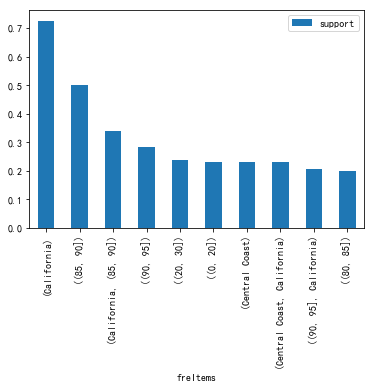

In [26]:
supp = [[item,suppData[item]] for items in L for item in items]
supp = pd.DataFrame(sorted(supp,key=lambda x:x[1],reverse=True),columns=list(['freItems','support']))
supp.head(10).plot.bar(x='freItems')

### 3.2  频繁项集与支持度结果分析

通过图中可以发现省份加利福尼亚出现最多，也就是说大部分葡萄酒来自于加利福尼亚州，同时区域一Central Coast出现也很多，说明大部分葡萄酒来自于此处。同时point评分属性主要集中于85-90分以及90-95之间符合正态分布，葡萄酒价格主要集中于20-30以及10-20之间，大部分属于廉价酒

### 3.3  关联规则及其模型评估可视化

#### 3.31 自信度与模型评估散点图

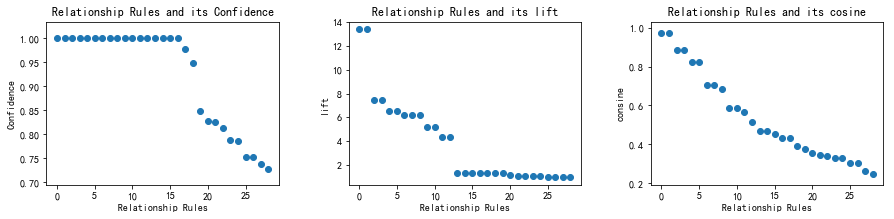

In [31]:
rules=pd.DataFrame(rules,columns=list(['frontItem', 'backItem','conf','support']))
rules.sort_values("conf",inplace=True,ascending = False)
x = range(len(rules))
fig  = plt.figure(figsize=(15,3))
plt.subplots_adjust(wspace =0.3, hspace =0.5)
fig1 = fig.add_subplot(1,3,1)
confidence = rules['conf']
#plt.xticks(x, frequenceItem, rotation=80)
fig1.scatter(x, confidence)
fig1.set_title('Relationship Rules and its Confidence')
plt.xlabel('Relationship Rules')
plt.ylabel('Confidence')

fig2 = fig.add_subplot(1,3,2)
liftRes.sort_values("lift",inplace=True,ascending = False)
lift = liftRes['lift']
fig2.scatter(x, lift)
fig2.set_title('Relationship Rules and its lift')
plt.xlabel('Relationship Rules')
plt.ylabel('lift')

fig3 = fig.add_subplot(1,3,3)
cosRes.sort_values("cosine",inplace=True,ascending = False)
allconf = cosRes['cosine']
fig3.scatter(x, allconf)
fig3.set_title('Relationship Rules and its cosine')
plt.xlabel('Relationship Rules')
plt.ylabel('consine')
plt.show()

结果分析：可以看出大部分关联规则具有高相关性,且都是正相关

#### 3.32 自信度与模型评估柱状图

,frontItem,backItem,conf,support,rulesItem
10,(Columbia Valley),(Washington),1.0,0.152252,frozenset({'Columbia Valley'})-->frozenset({'Washington'})
23,(Napa Valley),(California),1.0,0.091878,frozenset({'Napa Valley'})-->frozenset({'California'})
2,(Paso Robles),(California),1.0,0.050855,frozenset({'Paso Robles'})-->frozenset({'California'})
3,(Paso Robles),(Central Coast),1.0,0.050855,frozenset({'Paso Robles'})-->frozenset({'Central Coast'})
4,(Columbia Valley (WA)),(Columbia Valley),1.0,0.075674,frozenset({'Columbia Valley (WA)'})-->frozenset({'Columbia Valley'})
5,(Columbia Valley (WA)),(Washington),1.0,0.075674,frozenset({'Columbia Valley (WA)'})-->frozenset({'Washington'})
27,(Russian River Valley),"(California, Sonoma)",1.0,0.066273,"frozenset({'Russian River Valley'})-->frozenset({'California', 'Sonoma'})"
7,(Russian River Valley),(California),1.0,0.066273,frozenset({'Russian River Valley'})-->frozenset({'California'})
8,(Russian River Valley),(Sonoma),1.0,0.066273,frozenset({'Russian River Valley'})-->frozenset({'Sonoma'})
19,(Sonoma),(California),1.0,0.193707,frozenset({'Sonoma'})-->frozenset({'California'})


,rulesItem,lift
18,frozenset({'Oregon'})-->frozenset({'Willamette Valley'}),13.367508
17,frozenset({'Willamette Valley'})-->frozenset({'Oregon'}),13.367508
28,"frozenset({'Napa Valley'})-->frozenset({'Napa', 'California'})",7.418014
24,frozenset({'Napa Valley'})-->frozenset({'Napa'}),7.418014
26,"frozenset({'Columbia Valley (WA)'})-->frozenset({'Columbia Valley', 'Washington'})",6.568070
4,frozenset({'Columbia Valley (WA)'})-->frozenset({'Columbia Valley'}),6.568070
5,frozenset({'Columbia Valley (WA)'})-->frozenset({'Washington'}),6.223990
9,frozenset({'Washington'})-->frozenset({'Columbia Valley'}),6.223990
10,frozenset({'Columbia Valley'})-->frozenset({'Washington'}),6.223990
8,frozenset({'Russian River Valley'})-->frozenset({'Sonoma'}),5.162437


,rulesItem,cosine
9,frozenset({'Washington'})-->frozenset({'Columbia Valley'}),0.973454
10,frozenset({'Columbia Valley'})-->frozenset({'Washington'}),0.973454
17,frozenset({'Willamette Valley'})-->frozenset({'Oregon'}),0.886278
18,frozenset({'Oregon'})-->frozenset({'Willamette Valley'}),0.886278
28,"frozenset({'Napa Valley'})-->frozenset({'Napa', 'California'})",0.825385
24,frozenset({'Napa Valley'})-->frozenset({'Napa'}),0.825385
4,frozenset({'Columbia Valley (WA)'})-->frozenset({'Columbia Valley'}),0.705003
26,"frozenset({'Columbia Valley (WA)'})-->frozenset({'Columbia Valley', 'Washington'})",0.705003
5,frozenset({'Columbia Valley (WA)'})-->frozenset({'Washington'}),0.686288
27,"frozenset({'Russian River Valley'})-->frozenset({'California', 'Sonoma'})",0.584920


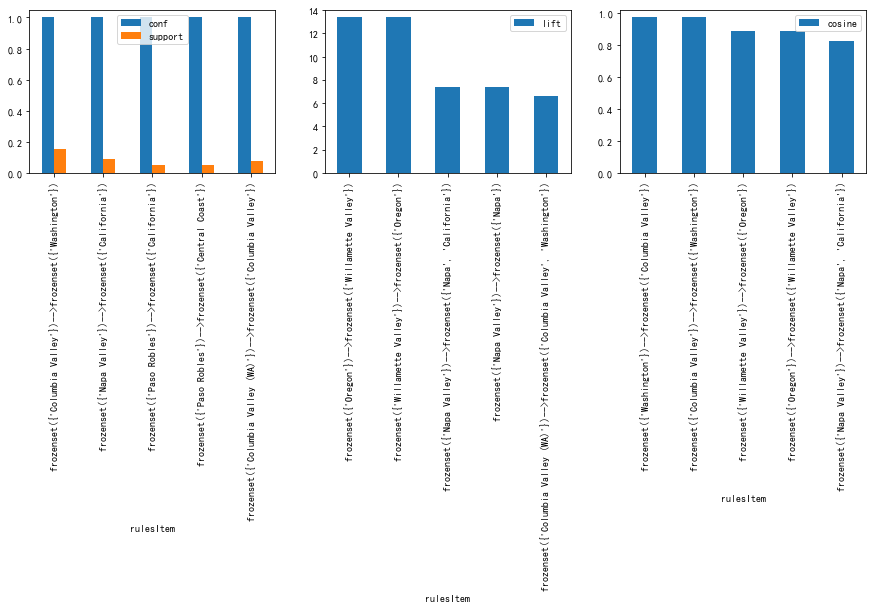

In [44]:
fig  = plt.figure(figsize=(15,3))
tmp = rules.copy(deep = True)
tmp['rulesItem'] = tmp.apply(lambda x: str(x['frontItem']) +'-->'+ str(x['backItem']), axis=1)
fig1 = fig.add_subplot(1,3,1)
tmp.head(5).plot.bar(x='rulesItem',ax = fig1)
fig2 = fig.add_subplot(1,3,2)
liftRes.head(5).plot.bar(x='rulesItem',ax = fig2)
fig3 = fig.add_subplot(1,3,3)
cosRes.head(5).plot.bar(x='rulesItem',ax = fig3)
display(tmp.head(10))
display(liftRes.head(10))
display(cosRes.head(10))

结果分析：可以看出不管是用哪个模型评估，省份区域之间的有着非常高的相关性

## 4.winemag-data-130k-v2.csv

由于数据集情况基本相同，不进行赘述，直接展示结果和分析

In [46]:
csv_file = 'Wine Reviews\winemag-data-130k-v2.csv'
data = pd.read_csv(csv_file,index_col=0)
data = data.dropna()
data.drop_duplicates(inplace=True)
points_bin = [0,75,80,85,90,95,100]
data['points'] = pd.cut(data['points'],points_bin).astype('str')
price_bin = [0,20,30,40,50,60,2100]
data['price'] = pd.cut(data['price'],price_bin).astype('str')
data.drop(['country','description'],axis=1,inplace=True)
data.head(5)

,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
4,Vintner's Reserve Wild Child Block,"(85, 90]","(60, 2100]",Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks
10,Mountain Cuvée,"(85, 90]","(0, 20]",California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Cabernet Sauvignon (Napa Valley),Cabernet Sauvignon,Kirkland Signature
23,Signature Selection,"(85, 90]","(20, 30]",California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Bianchi 2011 Signature Selection Merlot (Paso Robles),Merlot,Bianchi
25,King Ridge Vineyard,"(85, 90]","(60, 2100]",California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Castello di Amorosa 2011 King Ridge Vineyard Pinot Noir (Sonoma Coast),Pinot Noir,Castello di Amorosa
35,Hyland,"(85, 90]","(40, 50]",Oregon,McMinnville,Willamette Valley,Paul Gregutt,@paulgwine,Erath 2010 Hyland Pinot Noir (McMinnville),Pinot Noir,Erath


由于该数据集频繁项集更多，因此提高最低支持度，以便结果观察

In [50]:
myDat = np.array(data).tolist()
L,suppData = apriori(myDat, 0.1)
L

[[frozenset({'Chardonnay'}),
  frozenset({'(90, 95]'}),
  frozenset({'(30, 40]'}),
  frozenset({'Washington'}),
  frozenset({'Sean P. Sullivan'}),
  frozenset({'Columbia Valley (WA)'}),
  frozenset({'Columbia Valley'}),
  frozenset({'@wawinereport'}),
  frozenset({'(40, 50]'}),
  frozenset({'Sonoma'}),
  frozenset({'Matt Kettmann'}),
  frozenset({'Central Coast'}),
  frozenset({'@mattkettmann'}),
  frozenset({'(20, 30]'}),
  frozenset({'Virginie Boone'}),
  frozenset({'California'}),
  frozenset({'Cabernet Sauvignon'}),
  frozenset({'@vboone'}),
  frozenset({'(0, 20]'}),
  frozenset({'Willamette Valley'}),
  frozenset({'Pinot Noir'}),
  frozenset({'Paul Gregutt'}),
  frozenset({'Oregon'}),
  frozenset({'@paulgwine\xa0'}),
  frozenset({'(85, 90]'}),
  frozenset({'(60, 2100]'})],
 [frozenset({'@paulgwine\xa0', 'Columbia Valley'}),
  frozenset({'Columbia Valley', 'Paul Gregutt'}),
  frozenset({'@paulgwine\xa0', 'Washington'}),
  frozenset({'Paul Gregutt', 'Washington'}),
  frozenset({'(40

In [51]:
rules=generateRules(L,suppData,minConf=0.7)

frozenset({'@wawinereport'}) --> frozenset({'Columbia Valley'}) conf: 0.9086985391766268 support: 0.1335578002244669
frozenset({'Columbia Valley (WA)'}) --> frozenset({'Columbia Valley'}) conf: 1.0 support: 0.11130629971209681
frozenset({'Sean P. Sullivan'}) --> frozenset({'@wawinereport'}) conf: 1.0 support: 0.14697701654223394
frozenset({'@wawinereport'}) --> frozenset({'Sean P. Sullivan'}) conf: 1.0 support: 0.14697701654223394
frozenset({'Sean P. Sullivan'}) --> frozenset({'Columbia Valley'}) conf: 0.9086985391766268 support: 0.1335578002244669
frozenset({'@wawinereport'}) --> frozenset({'Washington'}) conf: 0.9631474103585657 support: 0.14156053286488068
frozenset({'Washington'}) --> frozenset({'Columbia Valley'}) conf: 0.9461766889383815 support: 0.24876787195627775
frozenset({'Columbia Valley'}) --> frozenset({'Washington'}) conf: 1.0 support: 0.24876787195627775
frozenset({'Columbia Valley (WA)'}) --> frozenset({'Washington'}) conf: 1.0 support: 0.11130629971209681
frozenset({'

In [52]:
liftRes = liftCheck(rules,suppData)
liftRes = pd.DataFrame(liftRes,columns=list(['rulesItem','lift']))
liftRes

,rulesItem,lift
0,frozenset({'@wawinereport'})-->frozenset({'Columbia Valley'}),3.652797
1,frozenset({'Columbia Valley (WA)'})-->frozenset({'Columbia Valley'}),4.019812
2,frozenset({'Sean P. Sullivan'})-->frozenset({'@wawinereport'}),6.803785
3,frozenset({'@wawinereport'})-->frozenset({'Sean P. Sullivan'}),6.803785
4,frozenset({'Sean P. Sullivan'})-->frozenset({'Columbia Valley'}),3.652797
5,frozenset({'@wawinereport'})-->frozenset({'Washington'}),3.663285
6,frozenset({'Washington'})-->frozenset({'Columbia Valley'}),3.803452
7,frozenset({'Columbia Valley'})-->frozenset({'Washington'}),3.803452
8,frozenset({'Columbia Valley (WA)'})-->frozenset({'Washington'}),3.803452
9,frozenset({'Sean P. Sullivan'})-->frozenset({'Washington'}),3.663285


In [53]:
cosRes = cosCheck(rules,suppData)
cosRes = pd.DataFrame(cosRes,columns=list(['rulesItem','cosine']))
cosRes

,rulesItem,cosine
0,frozenset({'@wawinereport'})-->frozenset({'Columbia Valley'}),0.698469
1,frozenset({'Columbia Valley (WA)'})-->frozenset({'Columbia Valley'}),0.668902
2,frozenset({'Sean P. Sullivan'})-->frozenset({'@wawinereport'}),1.000000
3,frozenset({'@wawinereport'})-->frozenset({'Sean P. Sullivan'}),1.000000
4,frozenset({'Sean P. Sullivan'})-->frozenset({'Columbia Valley'}),0.698469
5,frozenset({'@wawinereport'})-->frozenset({'Washington'}),0.720123
6,frozenset({'Washington'})-->frozenset({'Columbia Valley'}),0.972716
7,frozenset({'Columbia Valley'})-->frozenset({'Washington'}),0.972716
8,frozenset({'Columbia Valley (WA)'})-->frozenset({'Washington'}),0.650652
9,frozenset({'Sean P. Sullivan'})-->frozenset({'Washington'}),0.720123


,freItems,support
0,(California),0.572781
1,"((85, 90])",0.515200
2,"((90, 95])",0.393110
3,(Virginie Boone),0.286049
4,(@vboone),0.286049
5,"(@vboone, California)",0.286049
6,"(Virginie Boone, @vboone)",0.286049
7,"(Virginie Boone, California)",0.286049
8,"(Virginie Boone, California, @vboone)",0.286049
9,"(California, (85, 90])",0.278827


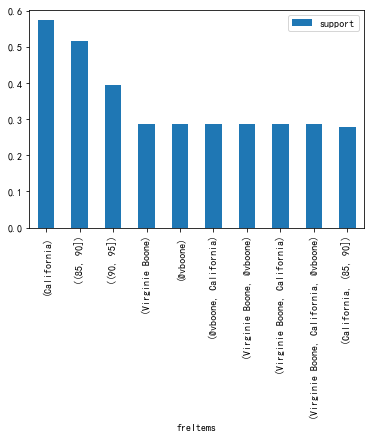

In [55]:
supp = [[item,suppData[item]] for items in L for item in items]
supp = pd.DataFrame(sorted(supp,key=lambda x:x[1],reverse=True),columns=list(['freItems','support']))
supp.head(10).plot.bar(x='freItems')
display(supp.head(10))

通过图中可以发现省份加利福尼亚出现最多，也就是说大部分葡萄酒来自于加利福尼亚州。同时point评分属性主要集中于85-90分以及90-95之间符合正态分布，评论者Virginie Boone出现次数很多，参与了较多葡萄酒的评论，推特名@vboone出现了很多次，@vboone应该是是Virginie Boone的推特名称

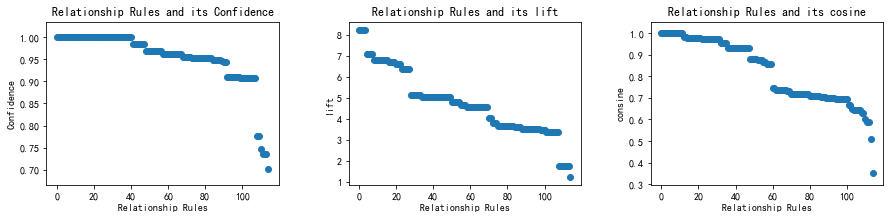

In [56]:
rules=pd.DataFrame(rules,columns=list(['frontItem', 'backItem','conf','support']))
rules.sort_values("conf",inplace=True,ascending = False)
x = range(len(rules))
fig  = plt.figure(figsize=(15,3))
plt.subplots_adjust(wspace =0.3, hspace =0.5)
fig1 = fig.add_subplot(1,3,1)
confidence = rules['conf']
#plt.xticks(x, frequenceItem, rotation=80)
fig1.scatter(x, confidence)
fig1.set_title('Relationship Rules and its Confidence')
plt.xlabel('Relationship Rules')
plt.ylabel('Confidence')

fig2 = fig.add_subplot(1,3,2)
liftRes.sort_values("lift",inplace=True,ascending = False)
lift = liftRes['lift']
fig2.scatter(x, lift)
fig2.set_title('Relationship Rules and its lift')
plt.xlabel('Relationship Rules')
plt.ylabel('lift')

fig3 = fig.add_subplot(1,3,3)
cosRes.sort_values("cosine",inplace=True,ascending = False)
allconf = cosRes['cosine']
fig3.scatter(x, allconf)
fig3.set_title('Relationship Rules and its cosine')
plt.xlabel('Relationship Rules')
plt.ylabel('consine')
plt.show()

,frontItem,backItem,conf,support,rulesItem
28,(Paul Gregutt),(@paulgwine ),1.0,0.273410,frozenset({'Paul Gregutt'})-->frozenset({'@paulgwine\xa0'})
24,(@vboone),(Virginie Boone),1.0,0.286049,frozenset({'@vboone'})-->frozenset({'Virginie Boone'})
26,(Virginie Boone),(California),1.0,0.286049,frozenset({'Virginie Boone'})-->frozenset({'California'})
97,"(@vboone, (85, 90])","(Virginie Boone, California)",1.0,0.143366,"frozenset({'@vboone', '(85, 90]'})-->frozenset({'Virginie Boone', 'California'})"
29,(@paulgwine ),(Paul Gregutt),1.0,0.273410,frozenset({'@paulgwine\xa0'})-->frozenset({'Paul Gregutt'})
92,"(@mattkettmann, Central Coast)","(Matt Kettmann, California)",1.0,0.189235,"frozenset({'@mattkettmann', 'Central Coast'})-->frozenset({'Matt Kettmann', 'California'})"
32,(Willamette Valley),(Oregon),1.0,0.117260,frozenset({'Willamette Valley'})-->frozenset({'Oregon'})
88,"(Central Coast, Matt Kettmann)","(@mattkettmann, California)",1.0,0.189235,"frozenset({'Central Coast', 'Matt Kettmann'})-->frozenset({'@mattkettmann', 'California'})"
85,"(Virginie Boone, Sonoma)","(@vboone, California)",1.0,0.143268,"frozenset({'Virginie Boone', 'Sonoma'})-->frozenset({'@vboone', 'California'})"
84,"(@vboone, Sonoma)","(Virginie Boone, California)",1.0,0.143268,"frozenset({'@vboone', 'Sonoma'})-->frozenset({'Virginie Boone', 'California'})"


,rulesItem,lift
64,"frozenset({'@paulgwine\xa0', 'Washington'})-->frozenset({'Paul Gregutt', 'Columbia Valley'})",8.250000
65,"frozenset({'@paulgwine\xa0', 'Columbia Valley'})-->frozenset({'Paul Gregutt', 'Washington'})",8.250000
63,"frozenset({'Paul Gregutt', 'Columbia Valley'})-->frozenset({'@paulgwine\xa0', 'Washington'})",8.250000
62,"frozenset({'Paul Gregutt', 'Washington'})-->frozenset({'@paulgwine\xa0', 'Columbia Valley'})",8.250000
77,"frozenset({'Washington', 'Sean P. Sullivan'})-->frozenset({'@wawinereport', 'Columbia Valley'})",7.064116
78,"frozenset({'Columbia Valley', 'Sean P. Sullivan'})-->frozenset({'@wawinereport', 'Washington'})",7.064116
81,"frozenset({'@wawinereport', 'Columbia Valley'})-->frozenset({'Washington', 'Sean P. Sullivan'})",7.064116
79,"frozenset({'@wawinereport', 'Washington'})-->frozenset({'Columbia Valley', 'Sean P. Sullivan'})",7.064116
41,"frozenset({'@wawinereport'})-->frozenset({'Columbia Valley', 'Sean P. Sullivan'})",6.803785
83,"frozenset({'@wawinereport'})-->frozenset({'Columbia Valley', 'Washington', 'Sean P. Sullivan'})",6.803785


,rulesItem,cosine
54,"frozenset({'@vboone'})-->frozenset({'Virginie Boone', 'California'})",1.000000
20,frozenset({'@mattkettmann'})-->frozenset({'Matt Kettmann'}),1.000000
24,frozenset({'@vboone'})-->frozenset({'Virginie Boone'}),1.000000
25,frozenset({'Virginie Boone'})-->frozenset({'@vboone'}),1.000000
55,"frozenset({'Virginie Boone'})-->frozenset({'@vboone', 'California'})",1.000000
28,frozenset({'Paul Gregutt'})-->frozenset({'@paulgwine\xa0'}),1.000000
29,frozenset({'@paulgwine\xa0'})-->frozenset({'Paul Gregutt'}),1.000000
19,frozenset({'Matt Kettmann'})-->frozenset({'@mattkettmann'}),1.000000
52,"frozenset({'Matt Kettmann'})-->frozenset({'@mattkettmann', 'California'})",1.000000
53,"frozenset({'@mattkettmann'})-->frozenset({'California', 'Matt Kettmann'})",1.000000


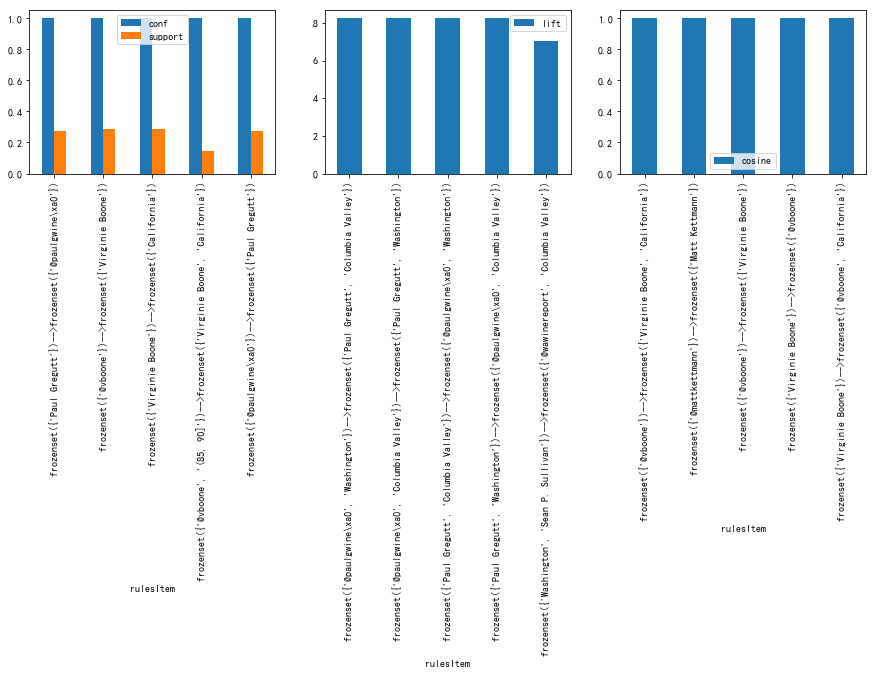

In [58]:
fig  = plt.figure(figsize=(15,3))
tmp = rules.copy(deep = True)
tmp['rulesItem'] = tmp.apply(lambda x: str(x['frontItem']) +'-->'+ str(x['backItem']), axis=1)
fig1 = fig.add_subplot(1,3,1)
tmp.head(5).plot.bar(x='rulesItem',ax = fig1)
fig2 = fig.add_subplot(1,3,2)
liftRes.head(5).plot.bar(x='rulesItem',ax = fig2)
fig3 = fig.add_subplot(1,3,3)
cosRes.head(5).plot.bar(x='rulesItem',ax = fig3)
display(tmp.head(20))
display(liftRes.head(20))
display(cosRes.head(20))

可以看出该数据集中区域省份之间，以及推特名和用户名之间有着很强的关联性